## Contents

1. [Background](#Background)
1. [Goal](#GoalB)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Background
**Model**: Ever heard about *Generative Adversarial Model* (GAN) ? How about *DeepFakes*? Many generative models nowadays use typical GAN architecture to model data distribution, then reconstruct and generate a completely new data.

We have seen many application of GAN such as face generation and face morphing. The underlying model behind GAN architecture that enables its generative capability is called *Variational Autoencoder* (VAE). Today we are going to take a look on how to build a simple Conditional VAE model.

**Dataset**: Kannada is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). TODO Kannada!!!!


## Goal
This tutorial will show you how to build and deploy on Sagemaker using Pytorch. The dataset we are using is the MNIST dataset. To get the feel, we will first see how a simple neural network can be used to generate a new handwritten digit image without human intervension. Then we will train and deploy our Pytorch model in Sagemaker environment.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.


---

## Setup 
_(Duration: 5 min)_

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).

---


### Packages

We will also setup our project by specifying libraries and modules that we need

In [1]:
%%bash
pip3 install --quiet torchsummary

In [2]:
import os, sys
import math
import json, logging, argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

from torchvision import datasets, transforms
from torchsummary import summary

# visualisation
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Meet and Greet Data: Kaggle Kannada MNIST
_(Duration: 20 min)_


Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

In [4]:
data_dir = 'data/Kannada'

### Downloading Kaggle Dataset

In [ ]:
%%bash
# Install Kaggle CLI using Python Pip
pip3 install --quiet kaggle
mkdir -p ~/.kaggle

# Copy API key file to where Kaggle expects it
# Make sure to upload kaggle key file next to this notebook
cp kaggle.json ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%bash

# Download Kannada MNIST from Kaggle
kaggle competitions download -c Kannada-MNIST

# Create our data directory
mkdir -p data/Kannada/raw
mkdir -p data/Kannada/processed

# Unzip to data/Kannada directory
unzip Kannada-MNIST.zip -d data/Kannada/raw

In [5]:
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print('data at: ' + os.path.join(dirname, filename))

data at: data/Kannada/raw/test.csv
data at: data/Kannada/raw/Dig-MNIST.csv
data at: data/Kannada/raw/train.csv
data at: data/Kannada/raw/sample_submission.csv
data at: data/Kannada/processed/validation_labels.csv
data at: data/Kannada/processed/test.csv
data at: data/Kannada/processed/train_labels.csv
data at: data/Kannada/processed/validation.csv
data at: data/Kannada/processed/test_labels.csv
data at: data/Kannada/processed/train.csv


### Loading Dataset with Pandas

In [6]:
from sklearn.model_selection import train_test_split

# # Load Data
train = pd.read_csv(os.path.join(data_dir, 'raw/train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'raw/Dig-MNIST.csv'))
submission_set = pd.read_csv(os.path.join(data_dir, 'raw/test.csv')).iloc[:,1:]

# # Seperate train data and labels
train_data = train.drop('label',axis=1)
train_targets = train['label']

# # Seperate test data and labels
test_images=test.drop('label',axis=1)
test_labels=test['label']

In [7]:
# Train Test Split for validation
train_images, val_images, train_labels, val_labels = train_test_split(train_data, 
                                                                     train_targets, 
                                                                     test_size=0.15)

In [8]:
# Reset Index
train_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)

val_images.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

test_images.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

### The shape of Kannada dataset

I'm in lop with the shape op u

In [9]:
train_images.iloc[20000:20005, 200:320]

,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,...,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319
20000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,64,153,96,19,64
20001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20002,0,0,0,0,0,0,0,14,126,255,...,0,0,0,0,0,0,0,12,223,33
20003,0,0,0,0,0,247,0,0,0,0,...,0,0,0,0,0,0,0,4,134,255
20004,0,0,0,0,0,0,0,0,0,165,...,0,0,0,0,0,0,0,0,229,255


In [10]:
print("Train Set: \n" + '-'*20)
print(train_images.shape)
print(train_labels.shape)

Train Set: 
--------------------
(51000, 784)
(51000,)


In [11]:
val_images.iloc[8000:8005, 200:320]

,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,...,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319
8000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,223,197,96
8001,0,0,0,0,0,0,0,239,48,175,...,0,0,0,0,0,0,0,0,0,0
8002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8003,0,0,0,0,0,255,0,0,0,255,...,0,0,0,0,0,0,0,0,0,0
8004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,232,86,12


In [12]:
print("\nValidation Set: \n"  + '-'*20)
print(val_images.shape)
print(val_labels.shape)


Validation Set: 
--------------------
(9000, 784)
(9000,)


In [13]:
test_images.iloc[5000:5005, 200:320]

,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,...,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319
5000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,98,157,189,255,255
5001,0,0,0,0,0,0,0,0,0,255,...,0,0,0,0,0,0,0,0,255,255
5002,0,0,0,0,0,0,0,173,100,0,...,0,0,0,0,0,0,0,0,0,0
5003,0,0,0,0,8,255,215,0,0,0,...,0,0,0,0,0,0,159,159,134,0
5004,0,0,0,0,159,223,32,159,223,32,...,0,0,0,0,13,13,214,255,255,244


In [14]:
print("\nTest Set: \n"  + '-'*20)
print(test_images.shape)
print(test_labels.shape)

print("\nSubmission: ")
print(submission_set.shape)


Test Set: 
--------------------
(10240, 784)
(10240,)

Submission: 
(5000, 784)


### Visualising Dataset Distribution

Let's look at the distribution of Kannada dataset across different classes.

In [18]:
train_dist = train_labels.value_counts(normalize = True)
test_dist = test_labels.value_counts(normalize = True)
submission_dist = train_labels.value_counts(normalize = True)

# display table for visualising dataset distribution
pd.DataFrame({
    'Trainset Distribution': train_dist,
    'Testset Distribution': test_dist,
    'Submissionset Distribution': submission_dist
})

,Trainset Distribution,Testset Distribution,Submissionset Distribution
0,0.099157,0.1,0.099157
1,0.100588,0.1,0.100588
2,0.098765,0.1,0.098765
3,0.099922,0.1,0.099922
4,0.099569,0.1,0.099569
5,0.100804,0.1,0.100804
6,0.100157,0.1,0.100157
7,0.100353,0.1,0.100353
8,0.100431,0.1,0.100431
9,0.100255,0.1,0.100255


## Pytorch Dataset Object & Data Loader

### Define Pytorch Dataset Object

In [19]:
class KannadaDataSet(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i,:]
        data = np.array(data).astype(np.uint8).reshape(IMGSIZE,IMGSIZE,1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            # for train set, val set, and test set
            return (data, self.y[i])
        else:
            # for kaggle submission
            # since submission set will not have labels
            return data

### Define Image Transformation Pipeline

In [20]:
IMGSIZE = 28

# Transformations for the train
train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.RandomCrop(IMGSIZE),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(), # automatically divide pixels by 255
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(), # automatically divide pixels by 255
]))

### Define Pytorch Data Loader

In [21]:
batch_size = 64

# Initialise dataset object for each set
train_data = KannadaDataSet(train_images, train_labels, train_trans)
val_data   = KannadaDataSet(val_images, val_labels, val_trans)
test_data  = KannadaDataSet(test_images, test_labels, val_trans)
submission_data = KannadaDataSet(submission_set, None, val_trans)

# Define Dataloader for each set
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_data, 
                        batch_size=batch_size, # batch_size=1000
                        shuffle=False)

test_loader = DataLoader(test_data,
                         batch_size=batch_size, # batch_size=1000
                         shuffle=False)

# for kaggle submission
submission_loader = DataLoader(submission_data,
                               batch_size=batch_size,
                               shuffle=False)

### Visualise Image in Training Batch

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

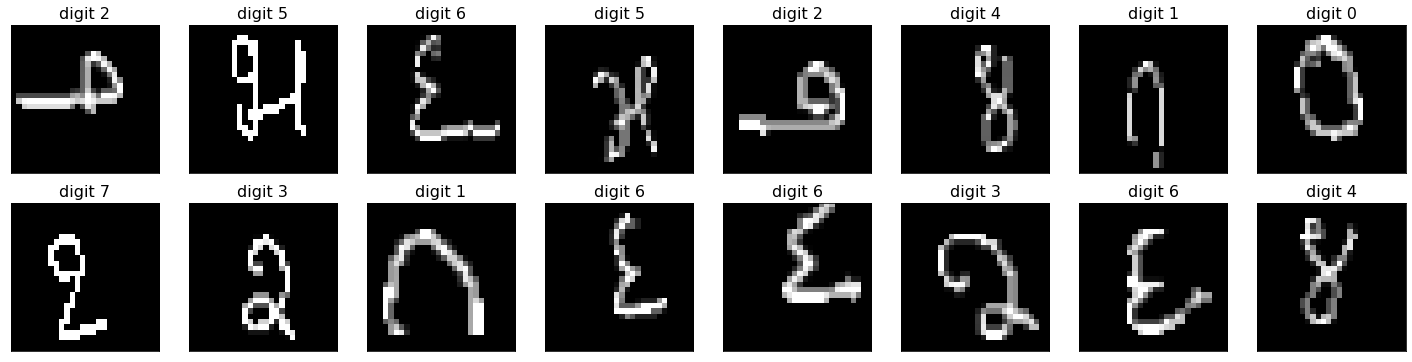

In [22]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title('digit ' + str(labels[idx].item()), fontsize=16)  # .item() gets single value in scalar tensor

### Visualise Image in Detail

Now let's see an image from MNIST dataset in detail. Notice how our image pixels only ranges from $(0, 1)$. This means that no further normalisation is required in the preprocessing step.

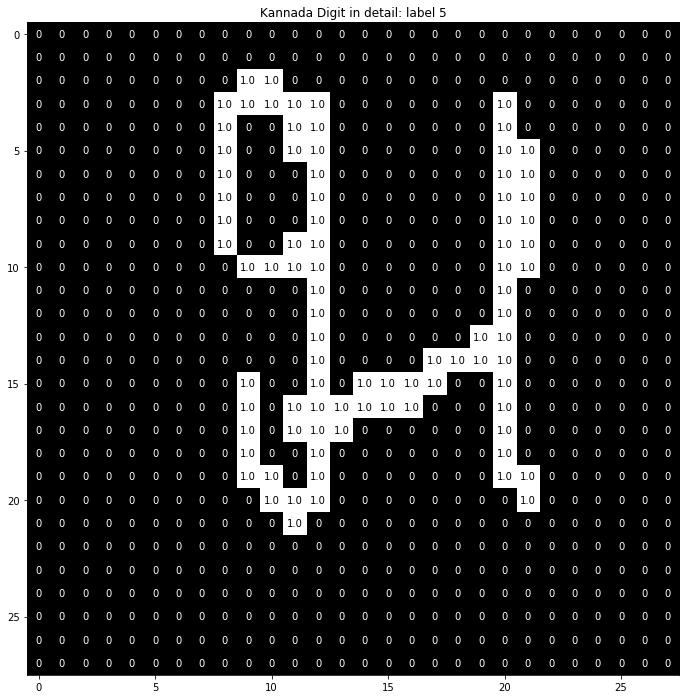

In [23]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

ax.set_title('Kannada Digit in detail: label %d' % labels[1].item());

In [24]:
# Save data to local folder first
train_images.to_csv(os.path.join(data_dir, 'processed/train.csv'), index=False, header=False)
train_labels.to_csv(os.path.join(data_dir, 'processed/train_labels.csv'), index=False, header=False)

val_images.to_csv(os.path.join(data_dir, 'processed/validation.csv'), index=False, header=False)
val_labels.to_csv(os.path.join(data_dir, 'processed/validation_labels.csv'), index=False, header=False)

test_images.to_csv(os.path.join(data_dir, 'processed/test.csv'), index=False, header=False)
test_labels.to_csv(os.path.join(data_dir, 'processed/test_labels.csv'), index=False, header=False)

## Building and Training CNN Model
_(Duration: 25 min)_



In [25]:
class KannadaCNN(nn.Module):
    """ Convolutional Neural Network
    """
    def __init__(self, drop_p=0.4):
        super().__init__()
        
        # First hidden layer
        self.conv2d_0 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.convbn_0 = nn.BatchNorm2d(num_features=64)

        self.conv2d_1 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.convbn_1 = nn.BatchNorm2d(num_features=64)

        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_1 = nn.Dropout2d(p=drop_p)

        # Second hidden layer
        self.conv2d_2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.convbn_2 = nn.BatchNorm2d(num_features=128)

        self.conv2d_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.convbn_3 = nn.BatchNorm2d(num_features=128)

        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_2 = nn.Dropout2d(p=drop_p)

        # Third hidden layer
        self.conv2d_4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convbn_4 = nn.BatchNorm2d(num_features=256)
        
        self.conv2d_5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.convbn_5 = nn.BatchNorm2d(num_features=256)

        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_3 = nn.Dropout(p=drop_p)

        # Dense fully connected layer
        self.dense_linear_1 = nn.Linear(256*3*3, 512)
        self.drop_4 = nn.Dropout(p=drop_p)

        self.dense_linear_2 = nn.Linear(512, 256)
        self.drop_5 = nn.Dropout(p=drop_p)

        self.dense_linear_3 = nn.Linear(256, 128)
        self.out_layer = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv2d_0(x)
        x = self.convbn_0(x)
        x = F.leaky_relu(x)
        
        x = self.conv2d_1(x)
        x = self.convbn_1(x)
        x = F.leaky_relu(x)

        x = self.pool_1(x)
        x = self.drop_1(x)

        x = self.conv2d_2(x)
        x = self.convbn_2(x)
        x = F.leaky_relu(x)

        x = self.conv2d_3(x)
        x = self.convbn_3(x)
        x = F.leaky_relu(x)

        x = self.pool_2(x)
        x = self.drop_2(x)

        x = self.conv2d_4(x)
        x = self.convbn_4(x)
        x = F.leaky_relu(x)
        
        x = self.conv2d_5(x)
        x = self.convbn_5(x)
        x = F.leaky_relu(x)
        
        x = self.pool_3(x)
        x = self.drop_3(x)

        x = x.view(-1, 256*3*3)
        x = self.dense_linear_1(x)
        x = F.relu(x)
        x = self.drop_4(x)
        
        x = self.dense_linear_2(x)
        x = F.relu(x)
        x = self.drop_5(x)
        
        x = self.dense_linear_3(x)
        x = F.relu(x)

        out = self.out_layer(x)
        return out

### Construct Neural Network from Pytorch Model Class

Now that we have defined our CNN model class using `nn.Module` and added the all layers, let's make it come to life by constructing the object so that we can use it to make prediction.

In [26]:
# Constructing our CNN module
model = KannadaCNN().to(device)
# initialise network
net = KannadaCNN().to(device)

# optimiser
optimiser = optim.Adam(net.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

# display model summary
summary(model, input_size=(1,IMGSIZE,IMGSIZE))  # IMGSIZE = 28

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]         102,464
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         MaxPool2d-5           [-1, 64, 14, 14]               0
         Dropout2d-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
       BatchNorm2d-8          [-1, 128, 14, 14]             256
            Conv2d-9          [-1, 128, 14, 14]         147,584
      BatchNorm2d-10          [-1, 128, 14, 14]             256
        MaxPool2d-11            [-1, 128, 7, 7]               0
        Dropout2d-12            [-1, 128, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]         295,168
      BatchNorm2d-14            [-1, 25

In [27]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [28]:
def train_helper(train_loader, model, optimizer, criterion,
                  epoch, device='cpu', log_interval=25):
    # set to training mode
    model.train()

    # training result to record
    train_loss = 0.0
    train_top1 = 0.0
    train_top5 = 0.0

    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        # convert tensor for current runtime device
        data, target = data.to(device), target.to(device)

        # reset optimiser gradient to zero
        optimizer.zero_grad()

        # feed forward
        out = model(data)
        
        # calculate loss and optimise network params
        loss = criterion(out, target)
        loss.backward()
        
        # optimize weight to account for loss/gradient
        optimizer.step()

        # calculate training accuracy for top1 and top5
        top1, top5 = accuracy(out, target, topk=(1,5))

        # update result records
        train_top1 += top1.item()
        train_top5 += top5.item()
        train_loss += loss.item()

        # logging loss output to stdout
        if batch_idx % log_interval == 0:
            print('Train Epoch: {:03d} [{:05d}/{:05d} ({:2.0f}%)] | '
                  'Top1 g Acc: {:4.1f} \t| Top5 Acc: {:4.1f} \t| Loss: {:.4f}'
                  .format(epoch, batch_idx * len(data), len(train_loader.sampler),
                      100 * batch_idx / len(train_loader),
                      top1, top5, loss.item()))

    # display training result
    train_loss /= len(train_loader.dataset)
    train_top1 /= len(train_loader) # average loss over mini-batches
    train_top5 /= len(train_loader) # average loss over mini-batches

    print('Training Summary Epoch: {:03d} | '
          'Average Top1 Acc: {:.2f}  | Average Top5 Acc: {:.2f} | Loss: {:.4f}'
          .format(epoch, train_top1, train_top5, train_loss))
    
    return train_loss, train_top1, train_top5 

In [29]:
def test_helper(test_loader, model, criterion, 
                 epoch, device='cpu'):
    # set to validation mode
    model.eval()
    
    test_loss = 0.0  # record testing loss
    test_top1 = 0.0
    test_top5 = 0.0
    for batch_idx, (data, target) in enumerate(test_loader, start=1):

        # convert tensor for current runtime device
        data, target = data.to(device), target.to(device)

        # generate image x
        out = model(data)

        # calculate loss and optimise network params
        loss = criterion(out, target)
        
        # calculate testing accuracy for top1 and top5
        top1, top5 = accuracy(out, target, topk=(1,5))

        # update test loss
        test_top1 += top1.item()
        test_top5 += top5.item()
        test_loss += loss.item()

    # display validation/testing result
    test_loss /= len(test_loader.dataset)  # average loss over all images
    test_top1 /= len(test_loader)
    test_top5 /= len(test_loader)

    print('Val/Test Summary Epoch: {:03d} | '
          'Average Top1 Acc: {:.2f}  | Average Top5 Acc: {:.2f} | Loss: {:.4f}'
          .format(epoch, test_top1, test_top5, test_loss))
    
    return test_loss, test_top1, test_top5

In [30]:
# ----------------------------
# TRAINING SESSION
# ----------------------------

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(1, 5 + 1):
    print('\n' + '-' * 100)
    # run session on training set
    train_loss, train_acc, _  = train_helper(train_loader, net, optimiser, criterion,
                                              epoch=epoch, device=device, log_interval=100)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # run session on validation set
    val_loss, val_acc, _ = test_helper(val_loader, net, criterion, epoch, device=device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# finally, run session testing set
print('\n' + 'Final Test Set Result:\n'+ '*' * 80)
test_helper(test_loader, net, criterion, epoch, device=device);


----------------------------------------------------------------------------------------------------
Train Epoch: 001 [06400/51000 (13%)] | Top1 Acc: 79.7 	| Top5 Acc: 96.9 | Loss: 0.8567
Train Epoch: 001 [12800/51000 (25%)] | Top1 Acc: 93.8 	| Top5 Acc: 100.0 | Loss: 0.2074
Train Epoch: 001 [19200/51000 (38%)] | Top1 Acc: 96.9 	| Top5 Acc: 98.4 | Loss: 0.1674
Train Epoch: 001 [25600/51000 (50%)] | Top1 Acc: 98.4 	| Top5 Acc: 100.0 | Loss: 0.0587
Train Epoch: 001 [32000/51000 (63%)] | Top1 Acc: 95.3 	| Top5 Acc: 100.0 | Loss: 0.0899
Train Epoch: 001 [38400/51000 (75%)] | Top1 Acc: 100.0 	| Top5 Acc: 100.0 | Loss: 0.0283
Train Epoch: 001 [44800/51000 (88%)] | Top1 Acc: 98.4 	| Top5 Acc: 100.0 | Loss: 0.1397
Training Summary Epoch: 001 | Top1 Acc: 88.83  | Top5 Acc: 98.06 | Loss: 0.0050
Val/Test Summary Epoch: 001 | Top1 Acc: 99.12  | Top5 Acc: 99.97 | Loss: 0.0004

----------------------------------------------------------------------------------------------------
Train Epoch: 002 [064

(0.011189822524102055, 84.169921875, 97.353515625)

### Visualise Training Session results

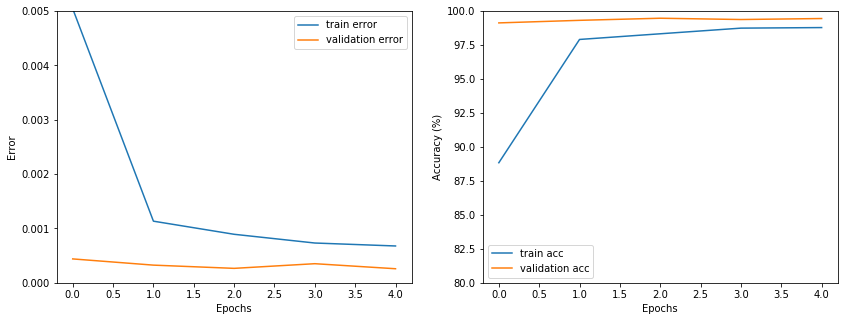

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot Error training vs validation
axes[0].plot(train_losses);
axes[0].plot(val_losses);

axes[0].set_ylabel('Error');
axes[0].set_xlabel('Epochs');

axes[0].set_ylim(0, 0.005);
axes[0].legend(labels=['train error', 'validation error']);

# Plot Accuracy training vs validation
axes[1].plot(train_accuracies);
axes[1].plot(val_accuracies);

axes[1].set_ylabel('Accuracy (%)');
axes[1].set_xlabel('Epochs');

axes[1].set_ylim(80, 100);
axes[1].legend(labels=['train acc', 'validation acc']);

### Writing Submission to Kaggle Competition

In [32]:
# Time to get the network's predictions on the test set
# Put the test set in a DataLoader

net.eval() # Safety first
predictions = torch.LongTensor().to(device) # Tensor for all predictions

# Go through the test set, saving the predictions in... 'predictions'
for images in submission_loader:
    images = images.to(device)
    preds = net(images)
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)

In [40]:
submission_pred_df = pd.DataFrame(predictions.cpu().detach().numpy())

In [43]:
submission_pred_df.to_csv(os.path.join(data_dir, 'kannada_sub_baseline.csv'), 
                          index=True, index_label='id', header=['label'])